<a href="https://colab.research.google.com/github/Chiaradisanto/Segmentation/blob/main/TestONsensor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [14]:

from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [15]:
#Load previously saved model
from keras.models import load_model
model = load_model("/gdrive/MyDrive/TESI/TEST/Sensor15-256-5e-5.h5", compile=False)

In [3]:

from matplotlib import pyplot as plt
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
#from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, add, concatenate,UpSampling2D,ZeroPadding2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import backend as K

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
val_img_path = "/gdrive/MyDrive/TESI/TEST/test6/test_images"
val_mask_path = "/gdrive/MyDrive/TESI/TEST/test6/test_masks"

In [5]:
# https://github.com/kivijoshi/TimeDistributedImageDataGenerator
import os
import sys

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import types
import numpy as np
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import DirectoryIterator

class TimeDistributedImageDataGenerator(ImageDataGenerator):
    def __init__(self,
                 featurewise_center=False,
                 samplewise_center=False,
                 featurewise_std_normalization=False,
                 samplewise_std_normalization=False,
                 zca_whitening=False,
                 zca_epsilon=1e-6,
                 rotation_range=0,
                 width_shift_range=0.,
                 height_shift_range=0.,
                 brightness_range=None,
                 shear_range=0.,
                 zoom_range=0.,
                 channel_shift_range=0.,
                 fill_mode='nearest',
                 cval=0.,
                 horizontal_flip=False,
                 vertical_flip=False,
                 rescale=None,
                 preprocessing_function=None,
                 data_format='channels_last',
                 validation_split=0.0,
                 # interpolation_order=1,
                 dtype='float32',
                 time_steps = 5):

                 self.time_steps = time_steps

                 super().__init__(featurewise_center=featurewise_center,
                                  samplewise_center=samplewise_center,
                                  featurewise_std_normalization=featurewise_std_normalization,
                                  samplewise_std_normalization=samplewise_std_normalization,
                                  zca_whitening=zca_whitening,
                                  zca_epsilon=zca_epsilon,
                                  rotation_range=rotation_range,
                                  width_shift_range=width_shift_range,
                                  height_shift_range=height_shift_range,
                                  brightness_range=brightness_range,
                                  shear_range=shear_range,
                                  zoom_range=zoom_range,
                                  channel_shift_range=channel_shift_range,
                                  fill_mode=fill_mode,
                                  cval=cval,
                                  horizontal_flip=horizontal_flip,
                                  vertical_flip=vertical_flip,
                                  rescale=rescale,
                                  preprocessing_function=preprocessing_function,
                                  data_format=data_format,
                                  validation_split=validation_split,
                                  # interpolation_order=interpolation_order,
                                  dtype=dtype)
    """Takes the path to a directory & generates batches of augmented data.
        # Arguments
            directory: string, path to the target directory.
                It should contain one subdirectory per class.
                Any PNG, JPG, BMP, PPM or TIF images
                inside each of the subdirectories directory tree
                will be included in the generator.
                See [this script](
                https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
                for more details.
            target_size: Tuple of integers `(height, width)`,
                default: `(256, 256)`.
                The dimensions to which all images found will be resized.
            color_mode: One of "grayscale", "rgb", "rgba". Default: "rgb".
                Whether the images will be converted to
                have 1, 3, or 4 channels.
            classes: Optional list of class subdirectories
                (e.g. `['dogs', 'cats']`). Default: None.
                If not provided, the list of classes will be automatically
                inferred from the subdirectory names/structure
                under `directory`, where each subdirectory will
                be treated as a different class
                (and the order of the classes, which will map to the label
                indices, will be alphanumeric).
                The dictionary containing the mapping from class names to class
                indices can be obtained via the attribute `class_indices`.
            class_mode: One of "categorical", "binary", "sparse",
                "input", or None. Default: "categorical".
                Determines the type of label arrays that are returned:
                - "categorical" will be 2D one-hot encoded labels,
                - "binary" will be 1D binary labels,
                    "sparse" will be 1D integer labels,
                - "input" will be images identical
                    to input images (mainly used to work with autoencoders).
                - If None, no labels are returned
                  (the generator will only yield batches of image data,
                  which is useful to use with `model.predict_generator()`).
                  Please note that in case of class_mode None,
                  the data still needs to reside in a subdirectory
                  of `directory` for it to work correctly.
            batch_size: Size of the batches of data (default: 32).
            shuffle: Whether to shuffle the data (default: True)
                If set to False, sorts the data in alphanumeric order.
            seed: Optional random seed for shuffling and transformations.
            save_to_dir: None or str (default: None).
                This allows you to optionally specify
                a directory to which to save
                the augmented pictures being generated
                (useful for visualizing what you are doing).
            save_prefix: Str. Prefix to use for filenames of saved pictures
                (only relevant if `save_to_dir` is set).
            save_format: One of "png", "jpeg"
                (only relevant if `save_to_dir` is set). Default: "png".
            follow_links: Whether to follow symlinks inside
                class subdirectories (default: False).
            subset: Subset of data (`"training"` or `"validation"`) if
                `validation_split` is set in `ImageDataGenerator`.
            interpolation: Interpolation method used to
                resample the image if the
                target size is different from that of the loaded image.
                Supported methods are `"nearest"`, `"bilinear"`,
                and `"bicubic"`.
                If PIL version 1.1.3 or newer is installed, `"lanczos"` is also
                supported. If PIL version 3.4.0 or newer is installed,
                `"box"` and `"hamming"` are also supported.
                By default, `"nearest"` is used.
        # Returns
            A `DirectoryIterator` yielding tuples of `(x, y)`
                where `x` is a numpy array containing a batch
                of images with shape `(batch_size, *target_size, channels)`
                and `y` is a numpy array of corresponding labels.
        """

    def flow_from_directory(self,
                            directory,
                            target_size=(256, 256),
                            color_mode='rgb',
                            classes=None,
                            class_mode='categorical',
                            batch_size=32,
                            shuffle=True,
                            seed=None,
                            save_to_dir=None,
                            save_prefix='',
                            save_format='png',
                            follow_links=False,
                            subset=None,
                            interpolation='nearest'):

        return TimeDistributedDirectoryIterator(
            directory,
            self,
            target_size=target_size,
            color_mode=color_mode,
            classes=classes,
            class_mode=class_mode,
            data_format=self.data_format,
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            save_to_dir=save_to_dir,
            save_prefix=save_prefix,
            save_format=save_format,
            follow_links=follow_links,
            subset=subset,
            interpolation=interpolation
        )
        


class TimeDistributedDirectoryIterator(DirectoryIterator):

    def _get_batches_of_transformed_samples(self, index_array):
        """Gets a batch of transformed samples.
        # Arguments
            index_array: Array of sample indices to include in batch.
        # Returns
            A batch of transformed samples.
        """
        TimeSteps = self.image_data_generator.time_steps
        batch_x = np.zeros((len(index_array),) + (TimeSteps,) + self.image_shape, dtype=self.dtype)#KJ
        # build batch of image data
        # self.filepaths is dynamic, is better to call it once outside the loop
        filepaths = self.filepaths
        for i, j in enumerate(index_array):
            for k in reversed(range(0,TimeSteps)):
                try:
                    img = load_img(filepaths[j-k],
                                color_mode=self.color_mode,
                                target_size=self.target_size,
                                interpolation=self.interpolation)
                    x = img_to_array(img, data_format=self.data_format)
                except:
                    print("Unexpected error:", sys.exc_info())
                    pass
                # Pillow images should be closed after `load_img`,
                # but not PIL images.
                if hasattr(img, 'close'):
                    img.close()
                if self.image_data_generator:
                    params = self.image_data_generator.get_random_transform(x.shape)
                    x = self.image_data_generator.apply_transform(x, params)
                    x = self.image_data_generator.standardize(x)
                batch_x[i][k] = x
        # optionally save augmented images to disk for debugging purposes
        if self.save_to_dir:
            for i, j in enumerate(index_array):
                img = array_to_img(batch_x[i], self.data_format, scale=True)
                fname = '{prefix}_{index}_{hash}.{format}'.format(
                    prefix=self.save_prefix,
                    index=j,
                    hash=np.random.randint(1e7),
                    format=self.save_format)
                img.save(os.path.join(self.save_to_dir, fname))
        # build batch of labels
        if self.class_mode == 'input':
            batch_y = batch_x.copy()
        elif self.class_mode in {'binary', 'sparse'}:
            batch_y = np.empty(len(batch_x), dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                batch_y[i] = self.classes[n_observation]
        elif self.class_mode == 'categorical':
            batch_y = np.zeros((len(batch_x), TimeSteps, len(self.class_indices)),
                               dtype=self.dtype)
            for i, n_observation in enumerate(index_array):
                for q in reversed(range(0,TimeSteps)):
                    batch_y[i,q,self.classes[n_observation-q]] = 1.
        elif self.class_mode == 'multi_output':
            batch_y = [output[index_array] for output in self.labels]
        elif self.class_mode == 'raw':
            batch_y = self.labels[index_array]
        else:
            return batch_x
        if self.sample_weight is None:
            return batch_x, batch_y
        else:
            return batch_x, batch_y, self.sample_weight[index_array]

In [6]:
seed=42
from keras.preprocessing.image import ImageDataGenerator


img_data_gen_args = dict(rescale=1./255,
                     rotation_range=90,
                     zoom_range=0.2,
                     brightness_range=[0.3,0.9],

                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     time_steps=3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant')

mask_data_gen_args = dict(
                     rotation_range=90,
                     zoom_range=0.2,
                     brightness_range=[0.3,0.9],

                     width_shift_range=0.3,
                     height_shift_range=0.3,
                     shear_range=0.5,
                     time_steps=3,
                     horizontal_flip=True,
                     vertical_flip=True,
                     fill_mode='constant',
                     preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
                
                     
                     ) #Binarize the output again. 

image_data_generator = TimeDistributedImageDataGenerator(**img_data_gen_args)
mask_data_generator = TimeDistributedImageDataGenerator(**mask_data_gen_args)

In [96]:
valid_img_generator = image_data_generator.flow_from_directory(val_img_path, 
                                                           seed=seed, 
                                                           batch_size=223,
                                                           color_mode = 'grayscale',           
                                                           target_size=(256,256),         
                                                           
                                                           class_mode=None) #Default batch size 32, if not specified here
valid_mask_generator = mask_data_generator.flow_from_directory(val_mask_path, 
                                                                      seed=seed, 
                                                           batch_size=223,
                                                           color_mode = 'grayscale',           
                                                           target_size=(256,256),         
                                                           class_mode=None)  #Default batch size 32, if not specified here

val_generator = zip(valid_img_generator, valid_mask_generator)

Found 223 images belonging to 1 classes.
Found 223 images belonging to 1 classes.


In [97]:
a,b=val_generator.__next__()


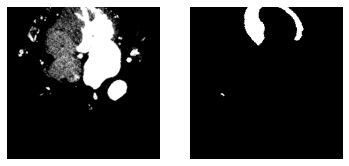

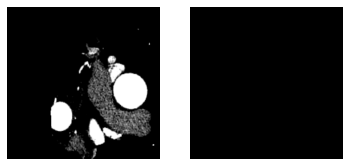

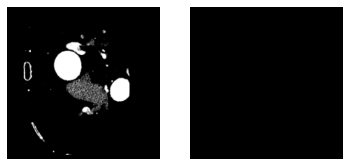

In [98]:

for i in range(0,3):
    image = a[i,0,:,:,0]
    #mask = np.argmax(y[i], axis=2)
    mask= b[i,0,:,:,0]
    plt.subplot(1,2,1)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='gray')
    plt.axis('off')
    plt.show()

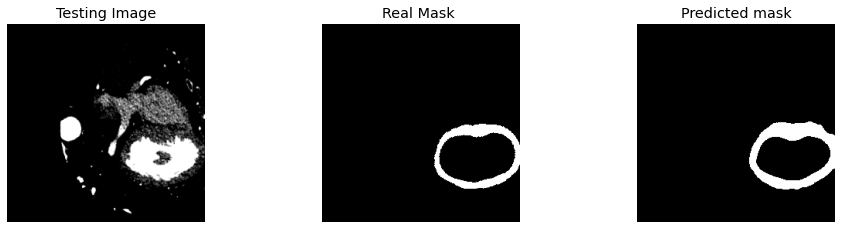

In [101]:
import random
test_img_number = random.randint(0, a.shape[0]-1)
test_img = a[test_img_number]
ground_truth=b[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input)[0,0,:,:,0] > 0.5).astype(np.uint8)
plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.axis('off')
plt.title('Testing Image')
plt.imshow(test_img[0,:,:,0], cmap='gray')


plt.subplot(232)
plt.title('Real Mask ')
plt.axis('off')
plt.imshow(ground_truth[0,:,:,0], cmap='gray')
plt.subplot(233)
plt.axis('off')
plt.title('Predicted mask')
plt.imshow(prediction, cmap='gray')

plt.show()

In [102]:
#IoU for a single image
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(ground_truth[0,:,:,0], prediction)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.83542067


In [103]:

import pandas as pd

IoU_values = []
for img in range(0, a.shape[0]):
    temp_img = a[img]
    ground_truth=b[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,0,:,:,0]> 0.5).astype(np.uint8)
    
    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[0,:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

    print(IoU)
    


df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]    
mean_IoU = df.mean().values
print("Mean IoU is: ", mean_IoU)

0.6619134
1.0
1.0
1.0
0.89082456
1.0
0.49884033
1.0
0.72869766
0.8445982
1.0
0.765985
0.8726939
0.49150848
0.49147797
1.0
0.49622536
1.0
0.8523247
0.4993286
0.49886322
0.75364935
1.0
1.0
1.0
1.0
0.8459971
1.0
0.49959564
1.0
0.8163754
1.0
0.69264627
0.84707725
1.0
1.0
1.0
1.0
1.0
0.7827441
1.0
0.87361825
0.80168545
1.0
1.0
1.0
1.0
1.0
0.49310303
1.0
0.49987793
1.0
0.4922409
1.0
1.0
0.48847198
1.0
0.76858586
0.79847413
0.7358478
0.49269104
0.66318214
0.7313079
0.84756696
1.0
0.85533416
0.83498585
1.0
1.0
1.0
1.0
0.49912262
1.0
0.84572995
1.0
0.49871063
1.0
0.4979477
0.49406433
1.0
0.7337839
1.0
1.0
1.0
0.70303464
0.85154057
1.0
0.49930573
1.0
1.0
1.0
0.49360657
1.0
1.0
1.0
1.0
0.7629626
1.0
1.0
0.80561465
1.0
1.0
0.49902344
1.0
1.0
0.8526702
0.4995346
0.49954987
0.83276534
0.49858093
0.4842682
1.0
1.0
0.4998169
0.83167946
0.8578391
0.7019711
0.6748616
0.49624634
1.0
0.69644135
1.0
0.77546537
1.0
0.4986801
1.0
1.0
1.0
0.83440876
0.4997177
1.0
0.85298634
0.8147148
1.0
0.46799052
1.0
1.0
1.